In [1]:
from hydra import initialize, compose

with initialize("../configs", version_base="1.2.0"):
    cfg = compose("config.yaml", overrides=["dataset=imagenet"])

import dotenv
dotenv.load_dotenv("../.env")

import os
os.environ["IMAGE_NET_PATH"]

'/home/mklasby/scratch/ILSVRC'

In [2]:
cfg.dataset.root

'/home/mklasby/scratch/ILSVRC'

In [3]:
from rigl_torch.datasets import get_dataloaders

In [4]:
train_loader, test_loader = get_dataloaders(cfg)

In [6]:
len(train_loader)*128

731136

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.functional as F

for imgs, labels in train_loader:
    break
# print(mini_batch.shape)

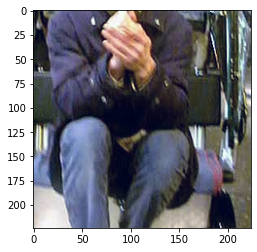

In [24]:
def norm_image(img):
    min = torch.abs(img.min())
    max = (img + min).max()
    return (img+min)/max

norm = norm_image(imgs[2])
plt.imshow(norm.permute(1,2,0))


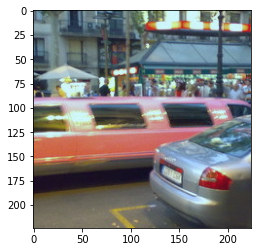

In [25]:
norm = norm_image(imgs[0])
plt.imshow(norm.permute(1,2,0))

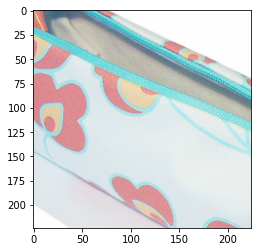

In [26]:
norm = norm_image(imgs[1])
plt.imshow(norm.permute(1,2,0))

In [12]:
imgs[0].max()

tensor(2.8865)

In [11]:
norm.max()

tensor(1.7155)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


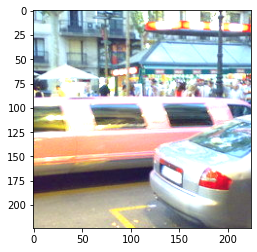

In [9]:
import matplotlib.pyplot as plt
plt.imshow(norm.permute(1,2,0))